In [2]:
import sys
sys.path.append('/home/jovyan/work')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from src.data_loader import cargar_oraciones_limpias, tokenize_sentences_by_char

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [144]:
# Definimos el modelo RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(RNNModel, self).__init__()
        # Capa de embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Capa LSTM
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        # Capa de salida
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        x = self.embedding(x)
        out, hidden = self.rnn(x)
        # Usamos la última salida del RNN
        out = self.fc(out.reshape(-1, out.size(2)))
        return out

In [145]:
# Preparar datos (convertir oraciones a índices de vocabulario)
sentences = cargar_oraciones_limpias(split="train", num_oraciones=10)
tokenized_sentences_by_char = tokenize_sentences_by_char(sentences)

In [146]:
# Crear vocabulario
vocab = list(set([char for sentence in tokenized_sentences_by_char for char in sentence]))
vocab_size = len(vocab)
char_to_idx = {char: idx for idx, char in enumerate(vocab)}

In [147]:
# Convertir las oraciones tokenizadas a índices
def encode_sentences(sentences):
    return [[char_to_idx[char] for char in sentence] for sentence in sentences]

encoded_sentences = encode_sentences(tokenized_sentences_by_char)

In [148]:
# Crear DataLoader para el entrenamiento
class CharDataset(Dataset):
    def __init__(self, sentences, seq_length):
        self.sentences = sentences
        self.seq_length = seq_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        
        # Si la oración es más corta que seq_length, rellénala con un valor de padding (por ejemplo, 0)
        padding_length = self.seq_length - len(sentence)
        
        # Aplicamos padding al final de la secuencia si es necesario
        if padding_length > 0:
            sentence = sentence + [0] * padding_length  # Añadimos padding (0) al final
        else:
            sentence = sentence[:self.seq_length]  # Si la secuencia es más larga que seq_length, truncamos
            
        # Convertir a tensor
        inputs = torch.tensor(sentence[:self.seq_length])
        targets = torch.tensor(sentence[:self.seq_length])
        
        return inputs, targets

In [149]:
# Definir la longitud de la secuencia
seq_length = 10  # Ajusta esto según lo necesites

# Filtrar oraciones que son más cortas que seq_length (si lo deseas)
filtered_sentences = [sentence for sentence in encoded_sentences if len(sentence) >= seq_length]

# Crear el dataset con las oraciones filtradas
dataset = CharDataset(filtered_sentences, seq_length)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Definir parámetros
embedding_dim = 100
hidden_dim = 128
output_size = vocab_size  # El tamaño de salida será igual al tamaño del vocabulario
epochs = 5

# Inicializamos el modelo, el criterio y el optimizador
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_size)

# Definir el criterio (CrossEntropyLoss) y el optimizador (Adam)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [156]:
# Lista para guardar la pérdida por época
training_loss = []

# Entrenamiento del modelo
num_epochs = epochs
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()

        # Enviar inputs y targets al modelo
        outputs = model(inputs)  # El modelo toma los inputs y devuelve las predicciones

        # Verificar las formas antes de aplanar
        print(f"Outputs shape (before flattening): {outputs.shape}")  # Debería ser (batch_size, seq_length, vocab_size)
        print(f"Targets shape (before flattening): {targets.shape}")  # Debería ser (batch_size, seq_length)

        # Aplanar los outputs y targets de manera correcta
        batch_size, seq_length = targets.size()  # Esto te da las dimensiones del batch y secuencia
        
        # Aseguramos que outputs y targets tengan la misma longitud antes de la pérdida
        outputs = outputs.view(-1, vocab_size)  # Aplanar a (batch_size * seq_length, vocab_size)
        targets = targets.view(-1)  # Aplanar a (batch_size * seq_length)

        # Verificar las formas después de aplanar
        print(f"Flattened Outputs shape: {outputs.shape}")  # Debería ser (batch_size * seq_length, vocab_size)
        print(f"Flattened Targets shape: {targets.shape}")  # Debería ser (batch_size * seq_length)

        # Verificar si los tamaños coinciden
        assert outputs.shape[0] == targets.shape[0], f"Outputs size {outputs.shape[0]} does not match targets size {targets.shape[0]}"

        # Calculamos la pérdida
        loss = criterion(outputs, targets)  # Los outputs y targets deben tener el mismo tamaño
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Guardamos la pérdida de la época
    training_loss.append(total_loss / len(dataloader))
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')


Outputs shape (before flattening): torch.Size([100, 57])
Targets shape (before flattening): torch.Size([10, 10])
Flattened Outputs shape: torch.Size([100, 57])
Flattened Targets shape: torch.Size([100])
Epoch 1, Loss: 2.064645767211914
Outputs shape (before flattening): torch.Size([100, 57])
Targets shape (before flattening): torch.Size([10, 10])
Flattened Outputs shape: torch.Size([100, 57])
Flattened Targets shape: torch.Size([100])
Epoch 2, Loss: 1.9169284105300903
Outputs shape (before flattening): torch.Size([100, 57])
Targets shape (before flattening): torch.Size([10, 10])
Flattened Outputs shape: torch.Size([100, 57])
Flattened Targets shape: torch.Size([100])
Epoch 3, Loss: 1.7782576084136963
Outputs shape (before flattening): torch.Size([100, 57])
Targets shape (before flattening): torch.Size([10, 10])
Flattened Outputs shape: torch.Size([100, 57])
Flattened Targets shape: torch.Size([100])
Epoch 4, Loss: 1.6485415697097778
Outputs shape (before flattening): torch.Size([100, 5

In [157]:
# Evaluar el modelo en los datos de validación
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Asumiendo que ya tienes un val_loader configurado de manera similar al dataloader de entrenamiento
# Puedes llamar a evaluate_model para calcular la pérdida en el conjunto de validación
val_loss = evaluate_model(model, dataloader, criterion)
print(f"Validation loss: {val_loss}")

Validation loss: 1.4144526720046997


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Dataset personalizado
class BPEDataset(Dataset):
    def __init__(self, token_seqs, vocab):
        self.data = []
        self.vocab = vocab
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        for seq in token_seqs:
            idx_seq = [self.token2idx[token] for token in seq if token in self.token2idx]
            if len(idx_seq) >= 2:
                self.data.append((idx_seq[:-1], idx_seq[1:]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, target_seq = self.data[idx]
        return torch.tensor(input_seq), torch.tensor(target_seq)

# Modelo RNN básico
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

# Entrenamiento del RNN
def entrenar_rnn(model, dataloader, vocab_size, epochs=10, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    training_loss = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for input_seq, target_seq in dataloader:
            output = model(input_seq)
            loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        training_loss.append(avg_loss)
        print(f"Época {epoch+1}/{epochs} - Pérdida: {avg_loss:.4f}")

    return training_loss

# Gráfico de pérdida
def graficar_perdida(losses):
    plt.plot(range(1, len(losses)+1), losses, marker='o')
    plt.title("Curva de pérdida - RNN")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.grid(True)
    plt.show()


In [7]:
import sys
sys.path.append('/home/jovyan/work/src')  # Agregar src al path
from evaluation import save_training_loss, evaluate_model


In [184]:
# Guardar la pérdida de entrenamiento
save_training_loss(training_loss)

# Evaluación en los datos de validación
val_loss = evaluate_model(model, dataloader, criterion, vocab_size)
print(f"Validation loss: {val_loss}")


Validation loss: 1.4144526720046997


##### CARGA DE DATOS

In [96]:
# Cargamos 5 oraciones
sentences = cargar_oraciones_limpias(split="train", num_oraciones=1000)

# Aplicamos tokenización por caracteres
tokenized_sentences_by_char = tokenize_sentences_by_char(sentences)

# Clonamos para aplicar BPE 
bpe_sentences = [sentence[:] for sentence in tokenized_sentences_by_char]


##### ENTRENAMIENTO DEL MODELO N-GRAMA

In [97]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Función para calcular perplejidad
def calculate_perplexity(X_ngram):
    # Sumar los log de las probabilidades para cada token en X_ngram
    log_perplexity = -np.sum(np.log(X_ngram.sum(axis=1)))/X_ngram.shape[0]
    return np.exp(log_perplexity)

# Creamos un modelo n-grama simple (trabajando con caracteres)
def train_ngram_model(corpus, n):
    vectorizer = CountVectorizer(ngram_range=(n, n), tokenizer=lambda x: x.split())
    X = vectorizer.fit_transform(corpus)
    return vectorizer, X


# Preparamos los datos tokenizados por caracteres
corpus = [' '.join(sentence) for sentence in tokenized_sentences_by_char]

# Entrenamos el modelo n-grama con bigramas
vectorizer, X_ngram = train_ngram_model(corpus, 2)

# Calculamos la perplejidad para el modelo n-grama
perplexity_ngram = calculate_perplexity(X_ngram)
print(f"Perplejidad del modelo n-grama: {perplexity_ngram}")

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Perplejidad del modelo n-grama: 0.0067004516927731215


In [4]:
from src.bpe import BytePairEncoding
from src.data_loader import cargar_oraciones_limpias

  n=3 → perplejidad = 786.5402
  n=4 → perplejidad = 6498.4094
  n=5 → perplejidad = 13521.6638
  n=3 → perplejidad = 3664.1335
  n=4 → perplejidad = 11238.5396
  n=5 → perplejidad = 15771.0040
  n=3 → perplejidad = 7216.5026
  n=4 → perplejidad = 12108.7824
  n=5 → perplejidad = 16776.6000
  n=3 → perplejidad = 7620.7295
  n=4 → perplejidad = 11703.2851
  n=5 → perplejidad = 15184.6376
  n=3 → perplejidad = 9495.1308
  n=4 → perplejidad = 12264.6154
  n=5 → perplejidad = 14025.7473


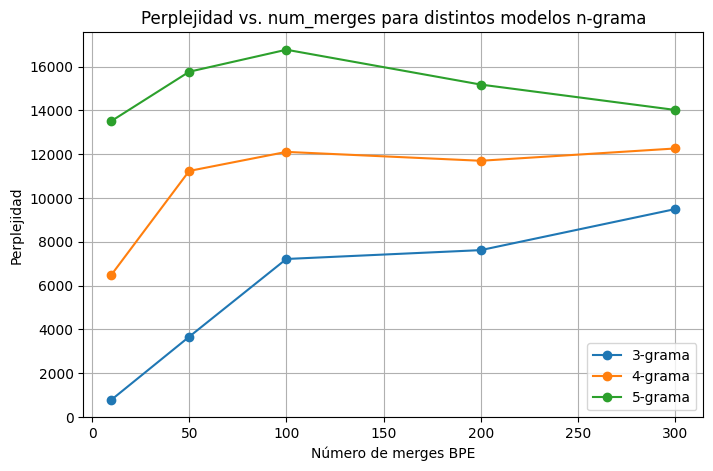

In [5]:
import nltk
from nltk.util import ngrams
from collections import Counter
import math
import matplotlib.pyplot as plt

def entrenar_ngrama(corpus_tokens, n):
    modelo = Counter(ngrams(corpus_tokens, n))
    contexto = Counter(ngrams(corpus_tokens, n - 1))
    return modelo, contexto

def calcular_perplejidad(texto_tokens, modelo, contexto, n):
    ngramas = list(ngrams(texto_tokens, n))
    N = len(ngramas)
    log_prob = 0
    for ng in ngramas:
        prob = (modelo[ng] + 1) / (contexto[ng[:-1]] + len(modelo))  # Laplace smoothing
        log_prob += math.log(prob)
    return math.exp(-log_prob / N)

# Experimento automático
num_merges_list = [10, 50, 100, 200, 300]
valores_n = [3, 4, 5]

oraciones_train = cargar_oraciones_limpias("train", 100)
oracion_test = "the quantum mechanics of multiverses"

resultados = {n: [] for n in valores_n}
                         
for num_merges in num_merges_list:
    bpe = BytePairEncoding(num_merges=num_merges)
    bpe.train(oraciones_train)
    
    corpus_tokens = []
    for oracion in oraciones_train:
        corpus_tokens.extend(bpe.tokenize(oracion.lower()))
    
    tokens_test = bpe.tokenize(oracion_test.lower())
                         
    for n in valores_n:                    
        modelo, contexto = entrenar_ngrama(corpus_tokens, n)
        perp = calcular_perplejidad(tokens_test, modelo, contexto, n)
        resultados[n].append(perp)
        print(f"  n={n} → perplejidad = {perp:.4f}")

# Graficar resultado
plt.figure(figsize=(8, 5))
for n in valores_n:
    plt.plot(num_merges_list, resultados[n], marker='o', label=f"{n}-grama")
plt.title("Perplejidad vs. num_merges para distintos modelos n-grama")
plt.xlabel("Número de merges BPE")
plt.ylabel("Perplejidad")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Nuevo experimento con merges grandes (dataset completo)
num_merges_list = [10000, 20000, 50000]
perplejidades_grandes = []

oraciones_train = cargar_oraciones_limpias("train", num_oraciones=50000)
oracion_test = "the quantum mechanics of multiverses"

for num_merges in num_merges_list:
    print(f"Entrenando BPE con {num_merges} merges...")
    bpe = BytePairEncoding(num_merges=num_merges)
    bpe.train(oraciones_train)
    
    corpus_tokens = []
    for oracion in oraciones_train:
        corpus_tokens.extend(bpe.tokenize(oracion.lower()))
    
    modelo, contexto = entrenar_ngrama(corpus_tokens, n=3)
    
    tokens_test = bpe.tokenize(oracion_test.lower())
    perp = calcular_perplejidad(tokens_test, modelo, contexto, n=3)
    perplejidades_grandes.append(perp)

# Graficar resultados
plt.figure(figsize=(8, 5))
plt.plot(num_merges_list, perplejidades_grandes, marker='o', color='red')
plt.title("Perplejidad vs. num_merges (grande)")
plt.xlabel("Número de merges BPE")
plt.ylabel("Perplejidad")
plt.grid(True)
plt.show()

Época 1/10 - Pérdida: 4.1296
Época 2/10 - Pérdida: 3.2669
Época 3/10 - Pérdida: 2.9167
Época 4/10 - Pérdida: 2.6772
Época 5/10 - Pérdida: 2.5148
Época 6/10 - Pérdida: 2.3801
Época 7/10 - Pérdida: 2.3179
Época 8/10 - Pérdida: 2.2802
Época 9/10 - Pérdida: 2.1688
Época 10/10 - Pérdida: 2.1432


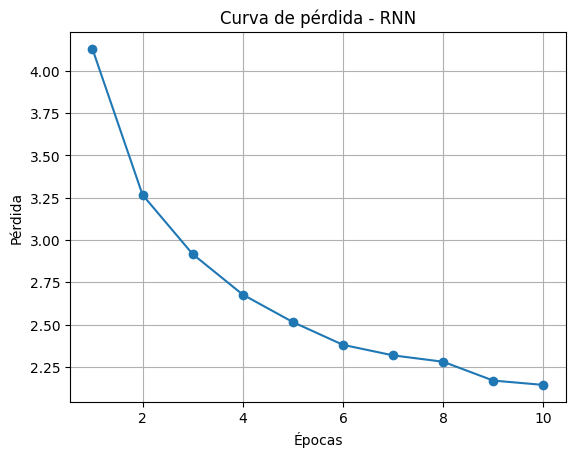

In [9]:
# 1. Preparar corpus y entrenar BPE
oraciones = cargar_oraciones_limpias("train", num_oraciones=100)
bpe = BytePairEncoding(num_merges=100)
bpe.train(oraciones)

# 2. Tokenizar oraciones
secuencias_tokens = [bpe.tokenize(oracion.lower()) for oracion in oraciones]

# 3. Crear dataset y dataloader
vocabulario = list(bpe.get_vocabulary().keys())
dataset = BPEDataset(secuencias_tokens, vocabulario)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 4. Crear y entrenar el modelo
vocab_size = len(vocabulario)
model = SimpleRNN(vocab_size=vocab_size, embed_size=32, hidden_size=64)
losses = entrenar_rnn(model, dataloader, vocab_size, epochs=10)

# 5. Graficar curva de pérdida
graficar_perdida(losses)

In [10]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), "modelo_rnn.pth")

# Guardar también el vocabulario si es necesario
import pickle
with open("vocabulario.pkl", "wb") as f:
    pickle.dump(vocabulario, f)

##### padding

In [11]:
from torch.nn.utils.rnn import pad_sequence

def collate_pad(batch):
    inputs, targets = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    return inputs_padded, targets_padded


In [12]:
#Crear dataset y dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_pad)

In [13]:
#Redefinir la función de entrenamiento con CrossEntropy que ignora el padding
def entrenar_rnn(model, dataloader, vocab_size, epochs=10, lr=0.01):
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignora el token de padding
    optimizer = optim.Adam(model.parameters(), lr=lr)
    training_loss = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for input_seq, target_seq in dataloader:
            output = model(input_seq)
            loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        training_loss.append(avg_loss)
        print(f"Época {epoch+1}/{epochs} - Pérdida: {avg_loss:.4f}")

    return training_loss

In [14]:
losses = entrenar_rnn(model, dataloader, vocab_size, epochs=10)

Época 1/10 - Pérdida: 2.9452
Época 2/10 - Pérdida: 2.7806
Época 3/10 - Pérdida: 2.7070
Época 4/10 - Pérdida: 2.6133
Época 5/10 - Pérdida: 2.5813
Época 6/10 - Pérdida: 2.5429
Época 7/10 - Pérdida: 2.4894
Época 8/10 - Pérdida: 2.5153
Época 9/10 - Pérdida: 2.4940
Época 10/10 - Pérdida: 2.4634


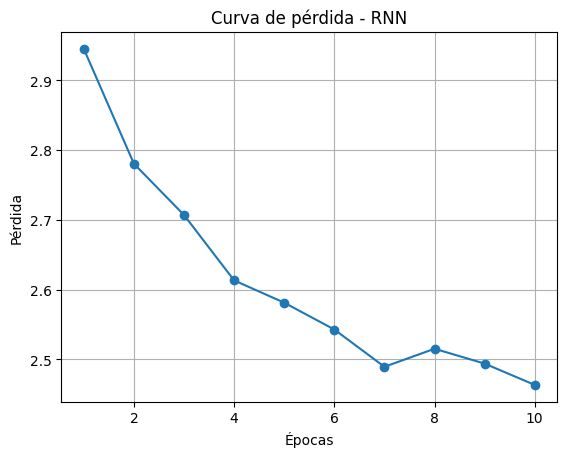

In [16]:
# Graficar curva de pérdida
graficar_perdida(losses)

In [17]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), "modelo_rnn_2.pth")

# Guardar también el vocabulario si es necesario
import pickle
with open("vocabulario.pkl", "wb") as f:
    pickle.dump(vocabulario, f)